In [1]:
import mne

# Load the EDF file
raw = mne.io.read_raw_edf("Sub002_3_16_2023-edf.edf", preload=True)

# Display some basic information about the data
raw.info


Extracting EDF parameters from /Users/sid/Documents/GitHub/EEG analysis/EEG-analysis/From EDF/Sub002_3_16_2023-edf.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 278249  =      0.000 ...  1112.996 secs...


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2023-03-06 13:48:40 UTC
 nchan: 32
 projs: []
 sfreq: 250.0 Hz
>

Using matplotlib as 2D backend.


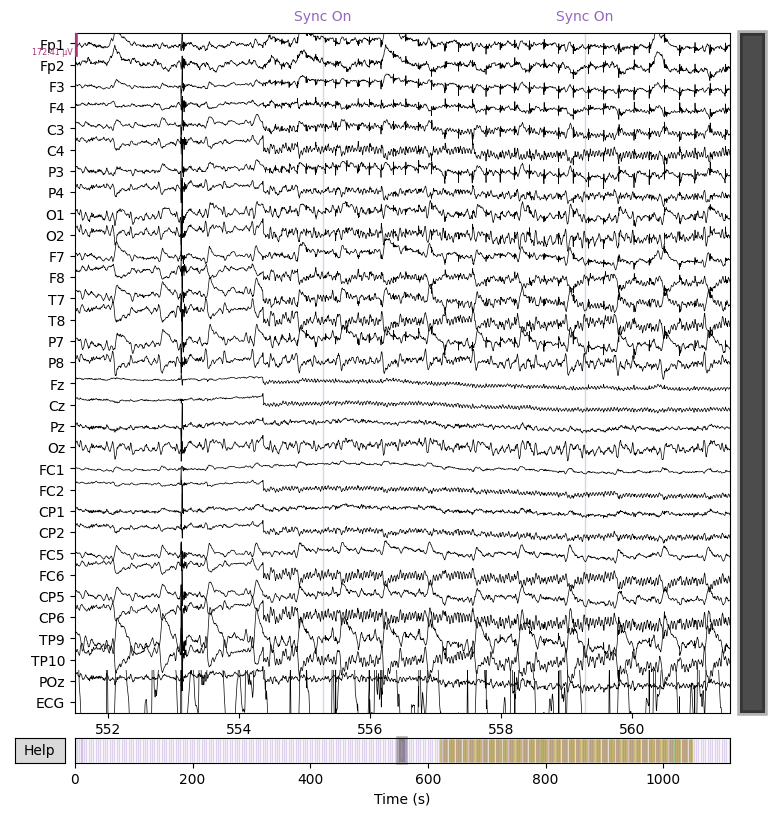

In [2]:
import matplotlib.pyplot as plt

# Plot a 10-second segment from the middle of the recording
midpoint_seconds = raw.times[-1] / 2
start, stop = raw.time_as_index([midpoint_seconds - 5, midpoint_seconds + 5])  # 10-second segment around the midpoint

fig = raw.plot(duration=10, start=midpoint_seconds - 5, n_channels=32, scalings="auto", show=True)
plt.show()


In [3]:
# Extract events from annotations
events_from_annot, event_dict = mne.events_from_annotations(raw)

# Filter out events with the "R149" marker
r149_id = event_dict.get('R149', None)
if r149_id:
    r149_events_from_annot = events_from_annot[events_from_annot[:, 2] == r149_id]
else:
    r149_events_from_annot = []

r149_events_from_annot


Used Annotations descriptions: ['New Segment', 'R 21', 'R149', 'Sync On']


array([[155232,      0,      3],
       [155732,      0,      3],
       [156232,      0,      3],
       [156732,      0,      3],
       [157232,      0,      3],
       [157732,      0,      3],
       [158232,      0,      3],
       [158732,      0,      3],
       [159232,      0,      3],
       [159732,      0,      3],
       [160232,      0,      3],
       [160732,      0,      3],
       [161232,      0,      3],
       [161732,      0,      3],
       [162232,      0,      3],
       [162732,      0,      3],
       [163232,      0,      3],
       [163732,      0,      3],
       [164232,      0,      3],
       [164732,      0,      3],
       [165232,      0,      3],
       [165732,      0,      3],
       [166232,      0,      3],
       [166732,      0,      3],
       [167232,      0,      3],
       [167732,      0,      3],
       [168232,      0,      3],
       [168732,      0,      3],
       [169232,      0,      3],
       [169732,      0,      3],
       [17

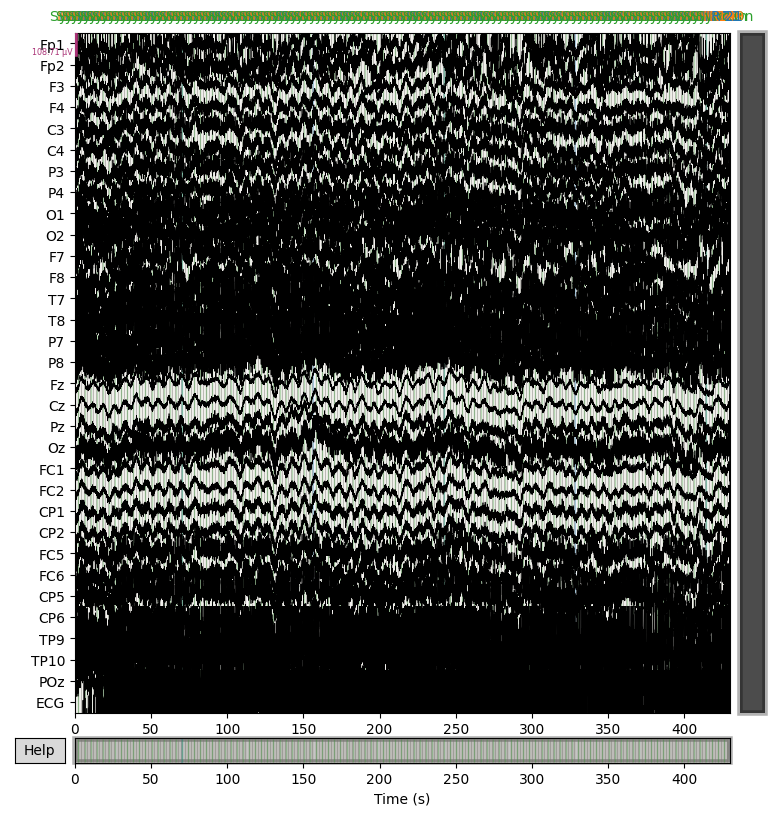

In [4]:
# Extract start and stop samples for the segment
start_sample = r149_events_from_annot[0][0]
stop_sample = r149_events_from_annot[-1][0] + int(2 * raw.info['sfreq'])  # Adding 2000ms (2 seconds) to the last marker

# Segment the data
segmented_r149 = raw.copy().crop(tmin=start_sample/raw.info['sfreq'], tmax=stop_sample/raw.info['sfreq'])

# Display the segmented data
fig_r149 = segmented_r149.plot(duration=stop_sample-start_sample, n_channels=32, scalings="auto", show=True)
plt.show()


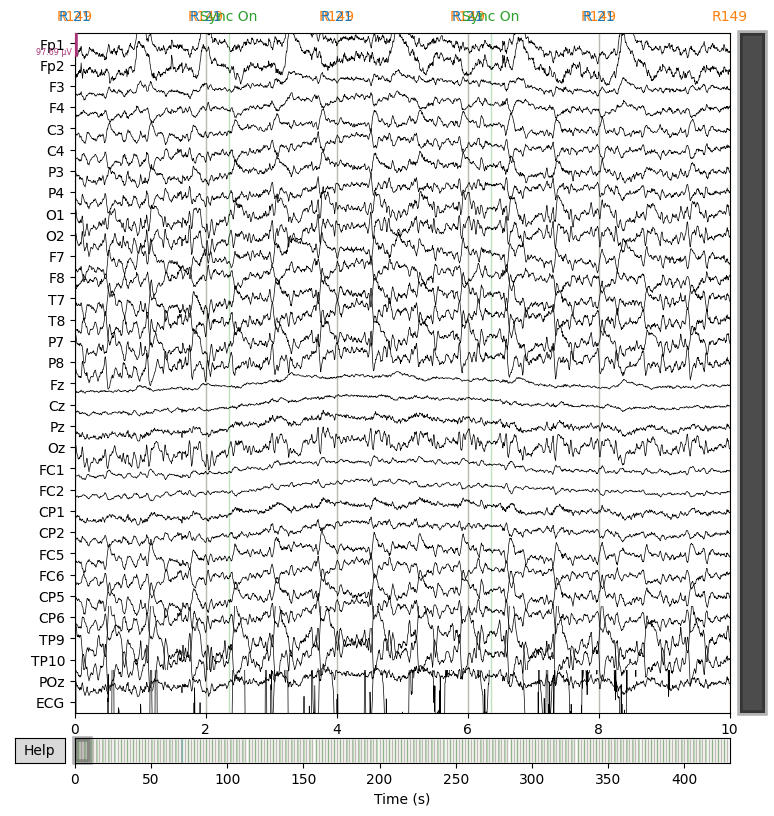

In [5]:
import matplotlib

# Display 10 seconds of the segmented data with scrolling functionality
fig_r149_scrollable = segmented_r149.plot(duration=10, n_channels=32, scalings="auto", show=True)
plt.show()

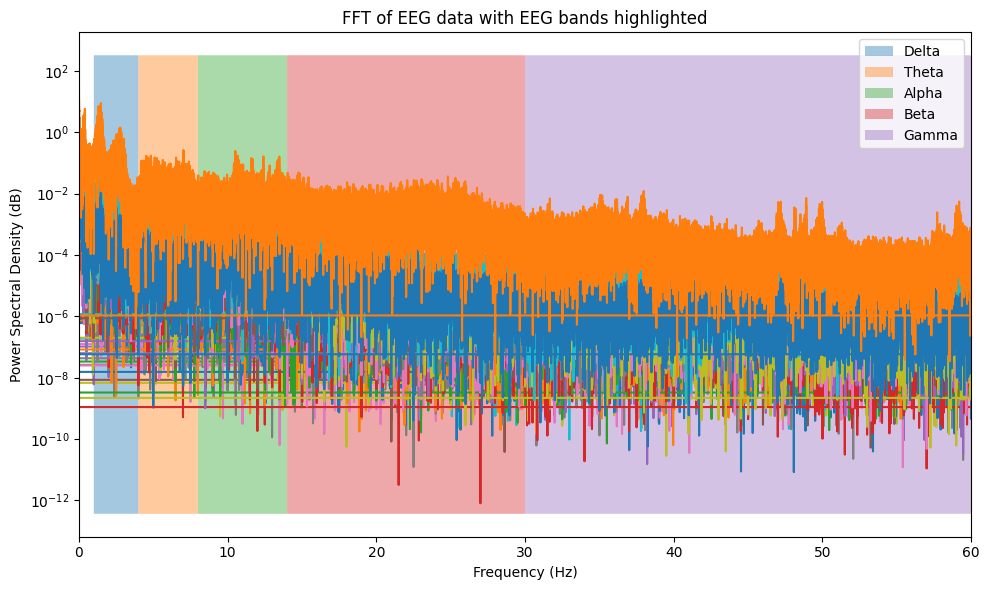

In [6]:
import numpy as np

# Compute the FFT of the data
data, times = segmented_r149[:, :]
psds = np.abs(np.fft.fft(data, axis=1)) ** 2
freqs = np.fft.fftfreq(data.shape[1], 1. / segmented_r149.info['sfreq'])

# Define EEG bands
bands = {
    'Delta': [1, 4],
    'Theta': [4, 8],
    'Alpha': [8, 14],
    'Beta': [14, 30],
    'Gamma': [30, 100]
}

# Plot FFT with shaded regions for each band
plt.figure(figsize=(10, 6))
plt.semilogy(freqs, psds.T)
plt.title('FFT of EEG data with EEG bands highlighted')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.xlim([0, 60])  # Limit to 60Hz for visualization

# Shade EEG bands
for band, (low, high) in bands.items():
    plt.fill_between(freqs, psds.min(), y2=psds.max(), where=np.logical_and(freqs >= low, freqs <= high), alpha=0.4, label=band)

plt.legend(loc='best')
plt.tight_layout()
plt.show()


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


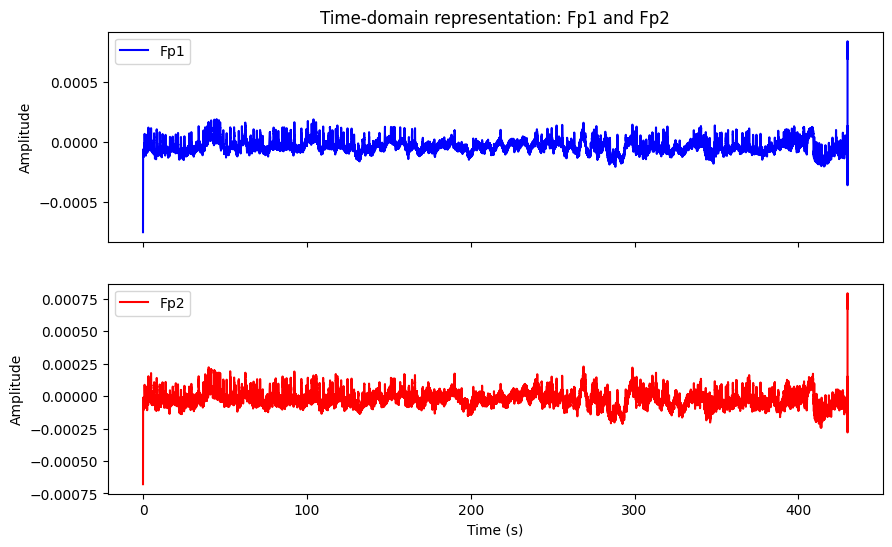

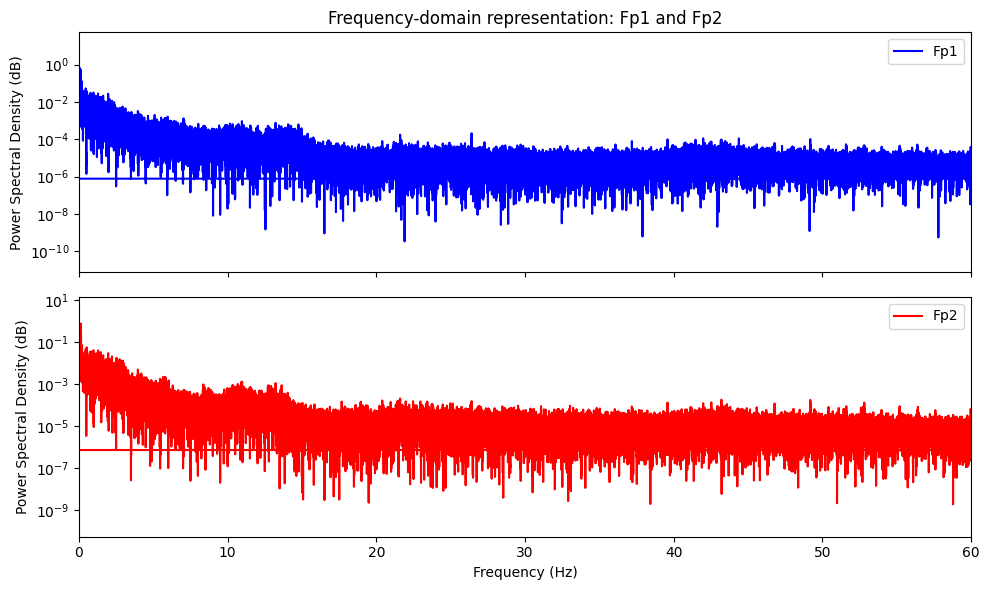

In [7]:
# Extract data for channels Fp1 and Fp2
fp1_data = segmented_r149.copy().pick_channels(['Fp1']).get_data()[0]
fp2_data = segmented_r149.copy().pick_channels(['Fp2']).get_data()[0]

# Time-domain plot
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(times, fp1_data, label='Fp1', color='b')
axs[1].plot(times, fp2_data, label='Fp2', color='r')
axs[0].set_title('Time-domain representation: Fp1 and Fp2')
axs[0].set_ylabel('Amplitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')
axs[0].legend(loc='best')
axs[1].legend(loc='best')

# Frequency-domain plot
psd_fp1 = np.abs(np.fft.fft(fp1_data)) ** 2
psd_fp2 = np.abs(np.fft.fft(fp2_data)) ** 2

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].semilogy(freqs, psd_fp1, label='Fp1', color='b')
axs[1].semilogy(freqs, psd_fp2, label='Fp2', color='r')
axs[0].set_title('Frequency-domain representation: Fp1 and Fp2')
axs[0].set_ylabel('Power Spectral Density (dB)')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Power Spectral Density (dB)')
axs[0].set_xlim([0, 60])  # Limit to 60Hz for visualization
axs[1].set_xlim([0, 60])  # Limit to 60Hz for visualization
axs[0].legend(loc='best')
axs[1].legend(loc='best')

plt.tight_layout()
plt.show()


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


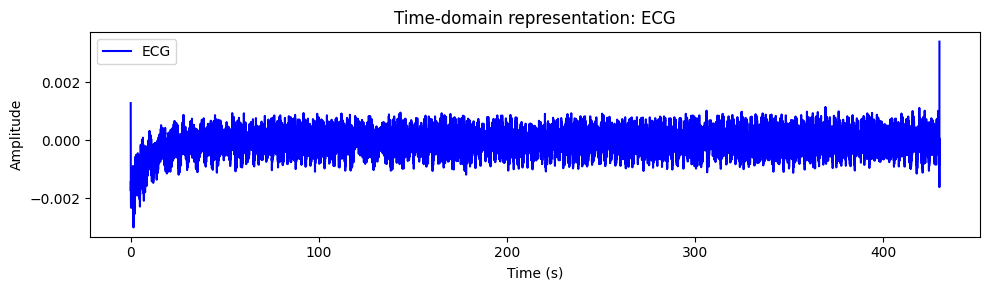

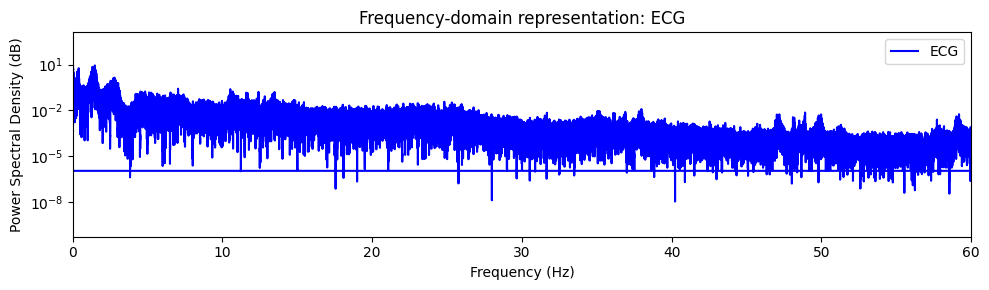

['ECG']

In [8]:
# Check for channels containing the name 'ECG' or 'EKG'
ecg_channels = [ch for ch in segmented_r149.info['ch_names'] if 'ECG' in ch or 'EKG' in ch]

if not ecg_channels:
    ecg_data_time = ecg_data_freq = None
    msg = "No ECG channel found in the dataset."
else:
    # Extract data for the first identified ECG channel
    ecg_channel = ecg_channels[0]
    ecg_data = segmented_r149.copy().pick_channels([ecg_channel]).get_data()[0]

    # Time-domain plot
    plt.figure(figsize=(10, 3))
    plt.plot(times, ecg_data, label=ecg_channel, color='b')
    plt.title(f'Time-domain representation: {ecg_channel}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # Frequency-domain plot
    psd_ecg = np.abs(np.fft.fft(ecg_data)) ** 2

    plt.figure(figsize=(10, 3))
    plt.semilogy(freqs, psd_ecg, label=ecg_channel, color='b')
    plt.title(f'Frequency-domain representation: {ecg_channel}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB)')
    plt.xlim([0, 60])  # Limit to 60Hz for visualization
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

ecg_channels


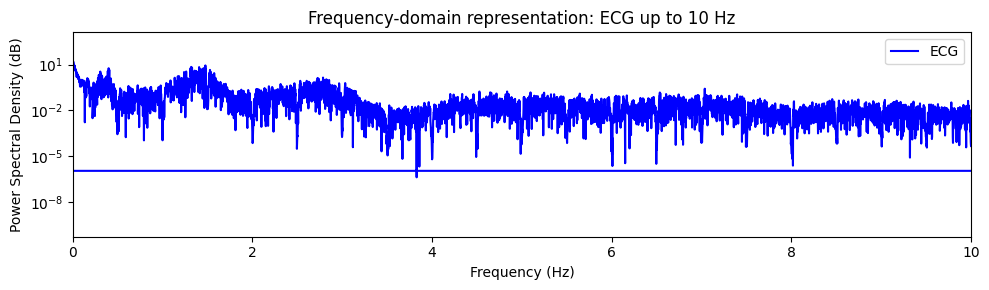

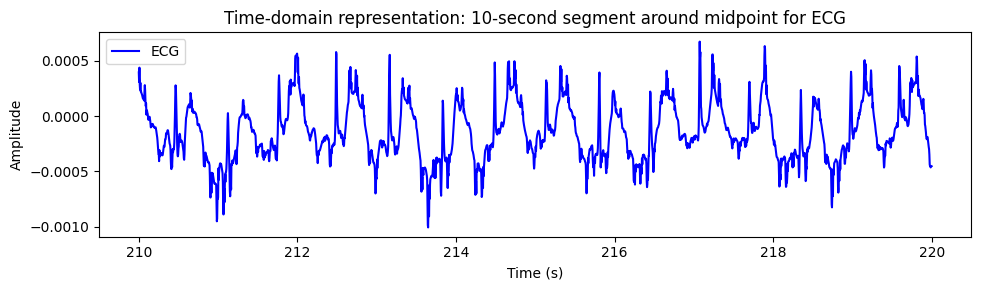

In [9]:
# Frequency-domain plot up to 10 Hz
plt.figure(figsize=(10, 3))
plt.semilogy(freqs, psd_ecg, label=ecg_channel, color='b')
plt.title(f'Frequency-domain representation: {ecg_channel} up to 10 Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.xlim([0, 10])  # Limit to 10Hz
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Time-domain plot of 10-second segment from the midpoint
midpoint_samples = len(times) // 2
start_sample = midpoint_samples - int(5 * segmented_r149.info['sfreq'])  # 5 seconds before the midpoint
stop_sample = midpoint_samples + int(5 * segmented_r149.info['sfreq'])   # 5 seconds after the midpoint

plt.figure(figsize=(10, 3))
plt.plot(times[start_sample:stop_sample], ecg_data[start_sample:stop_sample], label=ecg_channel, color='b')
plt.title(f'Time-domain representation: 10-second segment around midpoint for {ecg_channel}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [10]:
# 1. Preprocess the Data: High-pass filter to improve ICA performance
raw_highpass = segmented_r149.copy().filter(l_freq=1.0, h_freq=None)

# 2. Apply ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw_highpass)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.1s finished


Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.6s.


<ICA | raw data decomposition, method: fastica (fit in 33 iterations on 107501 samples), 20 ICA components (32 PCA components available), channel types: eeg, no sources marked for exclusion>

Creating RawArray with float64 data, n_channels=20, n_times=107501
    Range : 155232 ... 262732 =    620.928 ...  1050.928 secs
Ready.


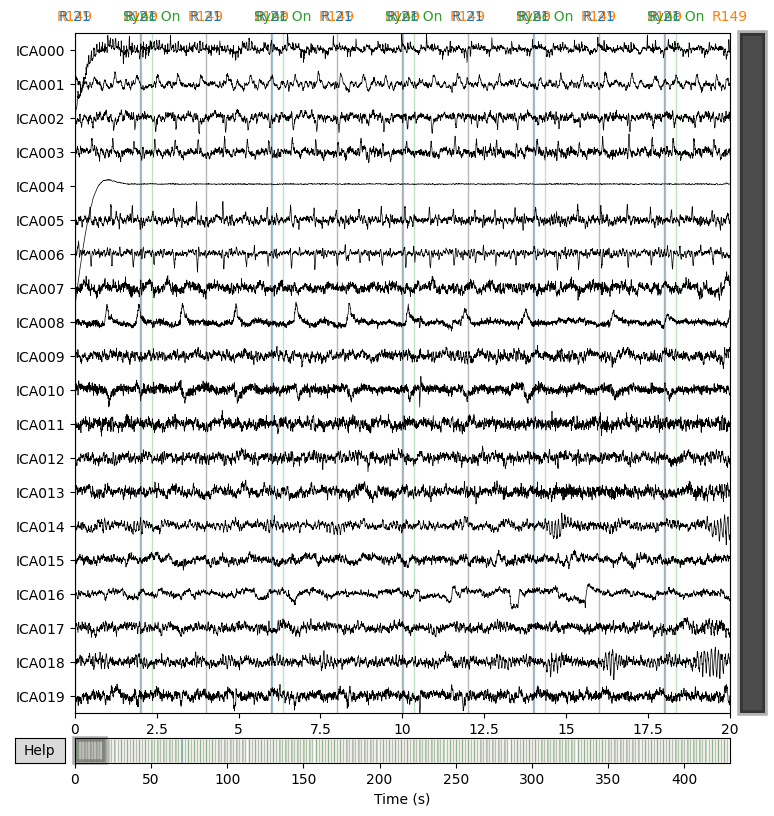

In [11]:
# Plot the time courses of the independent components
ica_fig_timecourses = ica.plot_sources(raw_highpass, show=False)
ica_fig_timecourses


In [12]:
from mne.time_frequency import psd_array_multitaper

# Extract sources data
sources_data = ica.get_sources(raw_highpass).get_data()

# Compute PSD for each component using the alternative method
psds_mt, freqs_mt = psd_array_multitaper(sources_data, fmin=0, fmax=3, sfreq=raw_highpass.info['sfreq'], adaptive=True)

# # Correctly plotting the PSDs for each component
# fig, axs = plt.subplots(len(psds_mt), 1, figsize=(10, 15), sharex=True)
# for idx, (psd, ax) in enumerate(zip(psds_mt, axs)):
#     ax.semilogy(freqs_mt, psd.T, label=f'Component {idx}')
#     ax.set_title(f'Component {idx}')
#     ax.legend(loc='best')
#     if idx == len(psds_mt) - 1:
#         ax.set_xlabel('Frequency (Hz)')
#     ax.set_ylabel('Power Spectral Density (dB)')
    
# plt.tight_layout()
# plt.show()


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


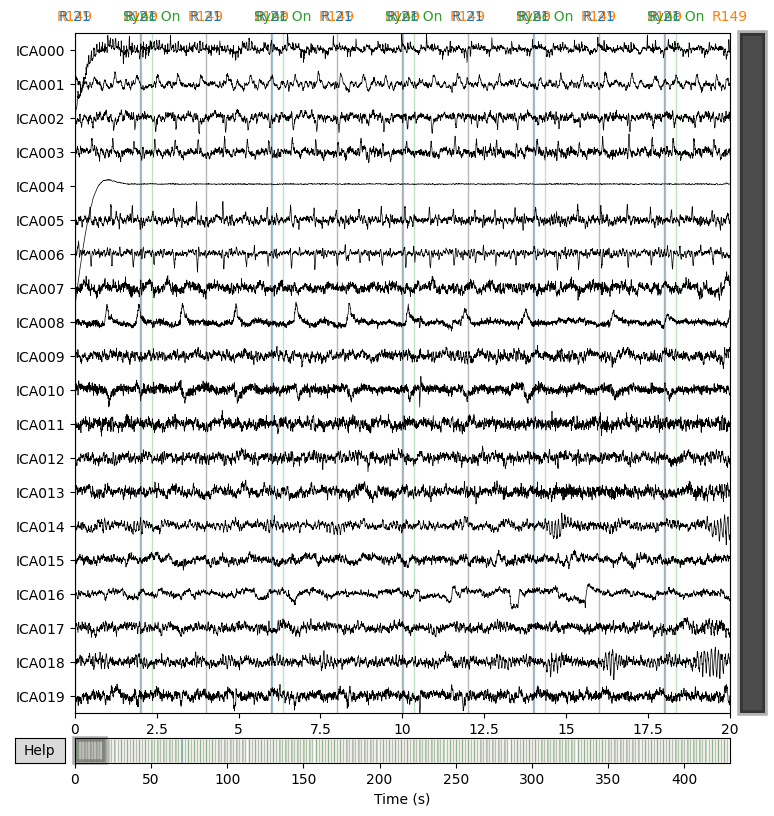

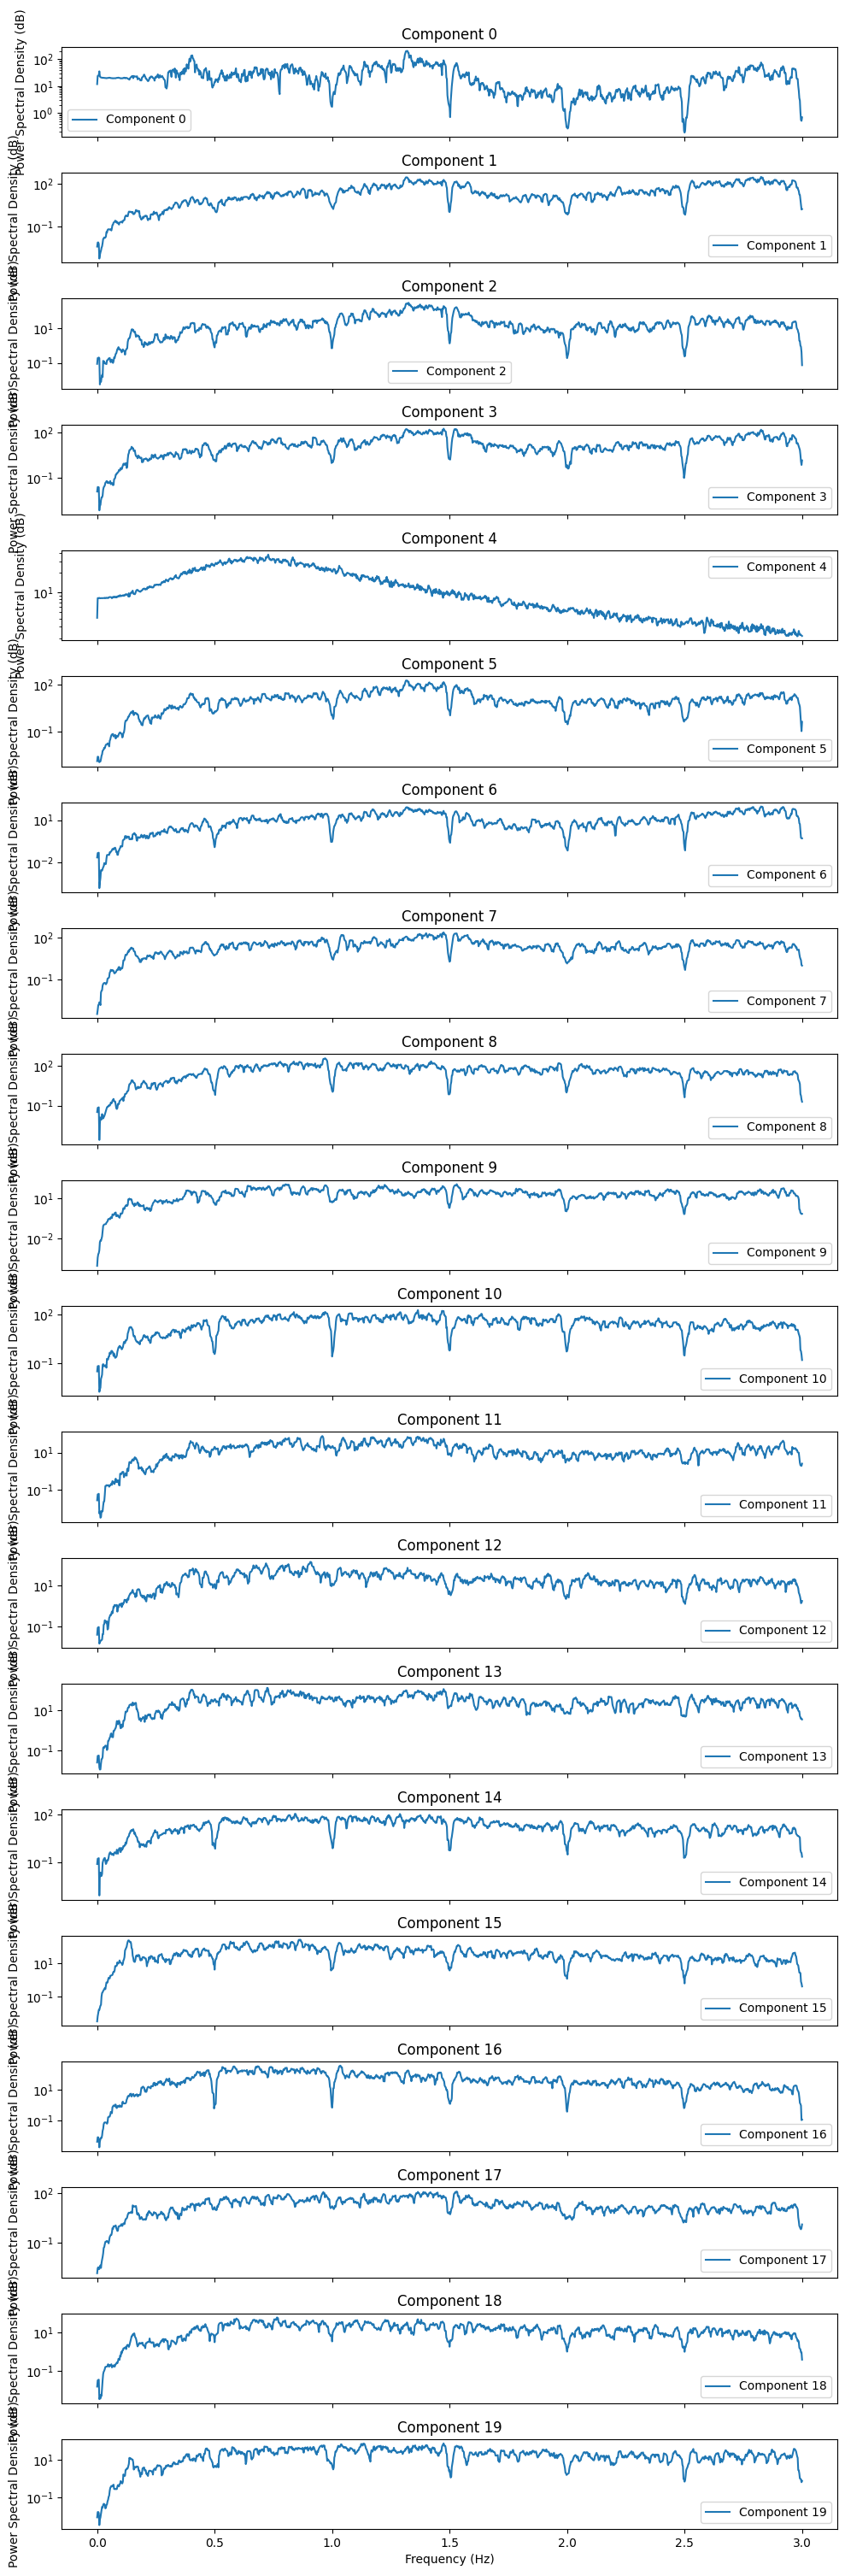

In [13]:
# Adjusting the figure size to allocate more vertical space for each subplot
fig, axs = plt.subplots(len(psds_mt), 1, figsize=(10, 30), sharex=True)
for idx, (psd, ax) in enumerate(zip(psds_mt, axs)):
    ax.semilogy(freqs_mt, psd.T, label=f'Component {idx}')
    ax.set_title(f'Component {idx}')
    ax.legend(loc='best')
    if idx == len(psds_mt) - 1:
        ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (dB)')
    
plt.tight_layout()
plt.show()


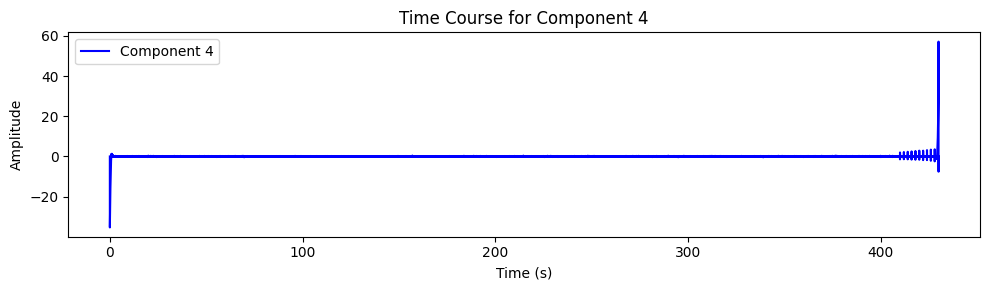

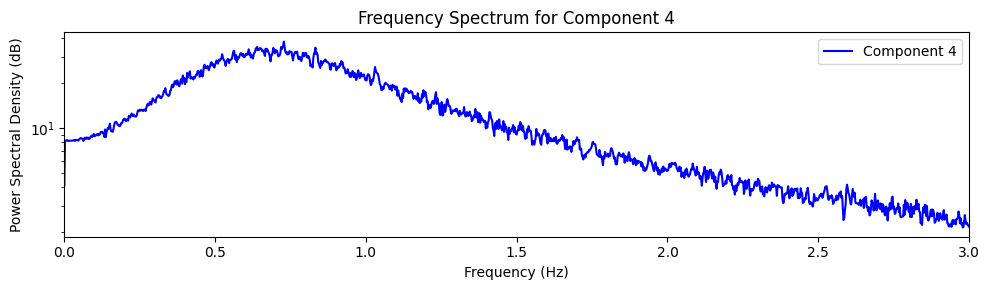

In [14]:
# Extract data for Component 4
component_4_data = ica.get_sources(raw_highpass).get_data(picks=[4])[0]

# Plot time course for Component 4
plt.figure(figsize=(10, 3))
plt.plot(times, component_4_data, label='Component 4', color='b')
plt.title('Time Course for Component 4')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Plot PSD for Component 4
plt.figure(figsize=(10, 3))
plt.semilogy(freqs_mt, psds_mt[4].T, label='Component 4', color='b')
plt.title('Frequency Spectrum for Component 4')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB)')
plt.xlim([0, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()


In [15]:
# Exclude Component 4
ica.exclude = [4]

# Apply the ICA solution to the data to remove the artifact
cleaned_data = ica.apply(raw_highpass.copy(), exclude=ica.exclude)

cleaned_data


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components


<RawEDF | Sub002_3_16_2023-edf.edf, 32 x 107501 (430.0 s), ~26.3 MB, data loaded>

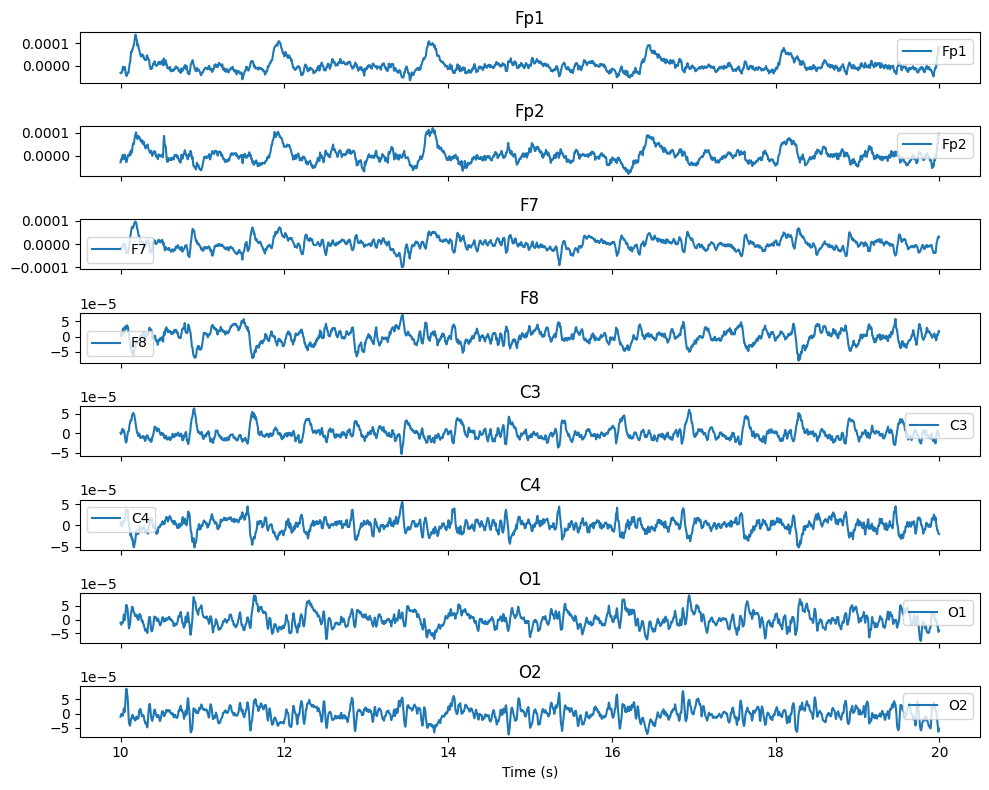

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


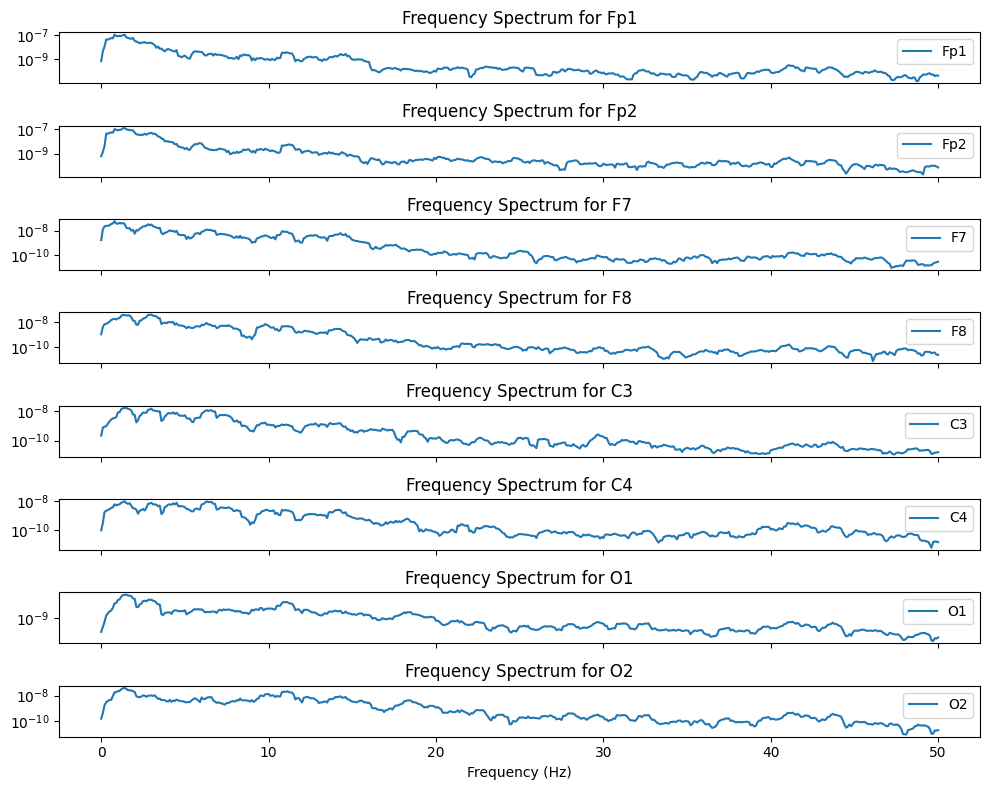

In [16]:
# Time-domain visualization of the cleaned EEG data
# For clarity, we'll plot the first 10 seconds of a few representative channels
start, stop = cleaned_data.time_as_index([10, 20])  # 10s to 20s segment
data, times = cleaned_data[:, start:stop]

# Selecting a few representative channels for visualization
selected_channels = ['Fp1', 'Fp2', 'F7', 'F8', 'C3', 'C4', 'O1', 'O2']
channel_indices = [cleaned_data.ch_names.index(ch) for ch in selected_channels]

fig, axs = plt.subplots(len(selected_channels), 1, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axs):
    ax.plot(times, data[channel_indices[idx]], label=selected_channels[idx])
    ax.set_title(selected_channels[idx])
    ax.legend(loc='best')
ax.set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Frequency-domain visualization of the cleaned EEG data
psds_cleaned, freqs_cleaned = psd_array_multitaper(data, fmin=0, fmax=50, sfreq=cleaned_data.info['sfreq'], adaptive=True)

fig, axs = plt.subplots(len(selected_channels), 1, figsize=(10, 8), sharex=True)
for idx, ax in enumerate(axs):
    ax.semilogy(freqs_cleaned, psds_cleaned[channel_indices[idx]].T, label=selected_channels[idx])
    ax.set_title(f'Frequency Spectrum for {selected_channels[idx]}')
    ax.legend(loc='best')
ax.set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()
